# Eigengene SVA Analysis

**Created**: 13 December 2021

## Environment

In [1]:
if (!requireNamespace("patchwork", quietly=TRUE)) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("GenomicRanges", quietly=TRUE)) {
    BiocManager::install("GenomicRanges")
}

if (!requireNamespace("circlize", quietly=TRUE)) {
    install.packages("circlize")
}

In [2]:
library(tidyverse)
library(data.table)
library(parallel)
library(patchwork)
library(GenomicRanges)
library(circlize)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterA

## Load Data

In [3]:
geno <- fread("~/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim")
colnames(geno) <- c("chr", "snp", "cM", "pos", "minor", "major")

## Module QTL from First PC

### Manhattan Plots

The genome-wide significance threshold is calculated using a Bonferroni correction of a significance threshold of 0.05. We performed tests for 66 individual eigengenes for 70300 SNPs. This threshold is slightly larger than 1e-8, so I will use that cutoff instead.

Under the null distribution, $t=\frac{\hat{\beta}}{SE}$ follows a T distribution with degrees of freedom close to $n$. The genomic inflation score measures the deviation from this expected distribution while accounting for outliers expected from a few true positives. The score is

$$\lambda = \frac{\text{median}(t^2)}{\text{median}(\chi_1^2)}$$

where $t$ is the T-statistic for $\beta$. Here, we assume that the T Distribution can be approximated as a standard normal distribution since $n$ is relatively large.

In [4]:
me.assocs <- do.call(rbind, lapply(list.files("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", pattern="ME_.*_1\\.tsv"), function(file) {
    file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", file)
    me.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
        as.data.frame() %>%
        dplyr::mutate(me = gsub("_1\\.tsv", "", file)) %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5, me)
}))

In [5]:
lambdas <- me.assocs %>%
    dplyr::group_by(me) %>%
    dplyr::summarize(lambda = median(qchisq(1 - p, 1)) / qchisq(0.5, 1))

In [6]:
num.modules <- length(unique(me.assocs$me))
num.snps <- length(unique(me.assocs$snp))

In [7]:
mqtl.lead <- me.assocs %>%
    dplyr::filter(p < 0.05 / (num.modules * num.snps)) %>%
    merge(., geno, by="snp") %>%
    dplyr::group_by(me, chr) %>%
    dplyr::slice_min(p, n=1) %>%
    dplyr::arrange(p)

head(mqtl.lead)

snp,beta,se,t,p,me,chr,cM,pos,minor,major
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
rs57213017,0.05440986,0.0008015134,67.88391,5.046513e-291,ME_69,17,0,45589540,C,G
rs9349181,-0.05097174,0.0009021488,-56.50037,1.318658e-250,ME_79,6,0,41217867,C,A
rs74011998,0.05274470,0.0011278543,46.76553,6.083896e-207,ME_97,15,0,48304516,C,T
rs999185,0.04612084,0.0010447149,44.14682,5.189250e-194,ME_94,12,0,9960659,T,C
rs8112960,-0.03160258,0.0009039899,-34.95899,2.856736e-150,ME_80,19,0,21592569,T,C
rs1677682,-0.01848770,0.0006136652,-30.12668,1.543047e-123,ME_82,5,0,80660774,A,C


In [8]:
write.csv(mqtl.lead, "~/gains_team282/nikhil/expression/eigengene_sva/lead_mqtl.csv", row.names=F, quote=F)

In [9]:
mqtl.all <- me.assocs %>%
    dplyr::filter(p < 0.05 / (num.modules * num.snps)) %>%
    merge(., geno, by="snp") %>%
    dplyr::group_by(me, chr) %>%
    dplyr::arrange(me, chr, pos)

head(mqtl.all)

snp,beta,se,t,p,me,chr,cM,pos,minor,major
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
rs1043879,0.010129813,0.001232190,8.220983,1.048905e-15,ME_101,1,0,25243590,C,T
rs9645452,0.013201977,0.001002150,13.173653,2.908400e-35,ME_101,1,0,25341835,T,C
rs3091242,0.012623894,0.001007970,12.524073,2.003450e-32,ME_101,1,0,25348294,C,T
rs3093614,0.012912368,0.001003548,12.866722,6.447898e-34,ME_101,1,0,25351353,A,T
rs1293259,0.009308084,0.001492895,6.234923,8.485031e-10,ME_101,1,0,25369344,A,G
rs644592,0.009194383,0.001511389,6.083400,2.082507e-09,ME_101,1,0,25376665,T,C


In [10]:
write.csv(mqtl.all, "~/gains_team282/nikhil/expression/eigengene_sva/all_mqtl.csv", row.names=F, quote=F)

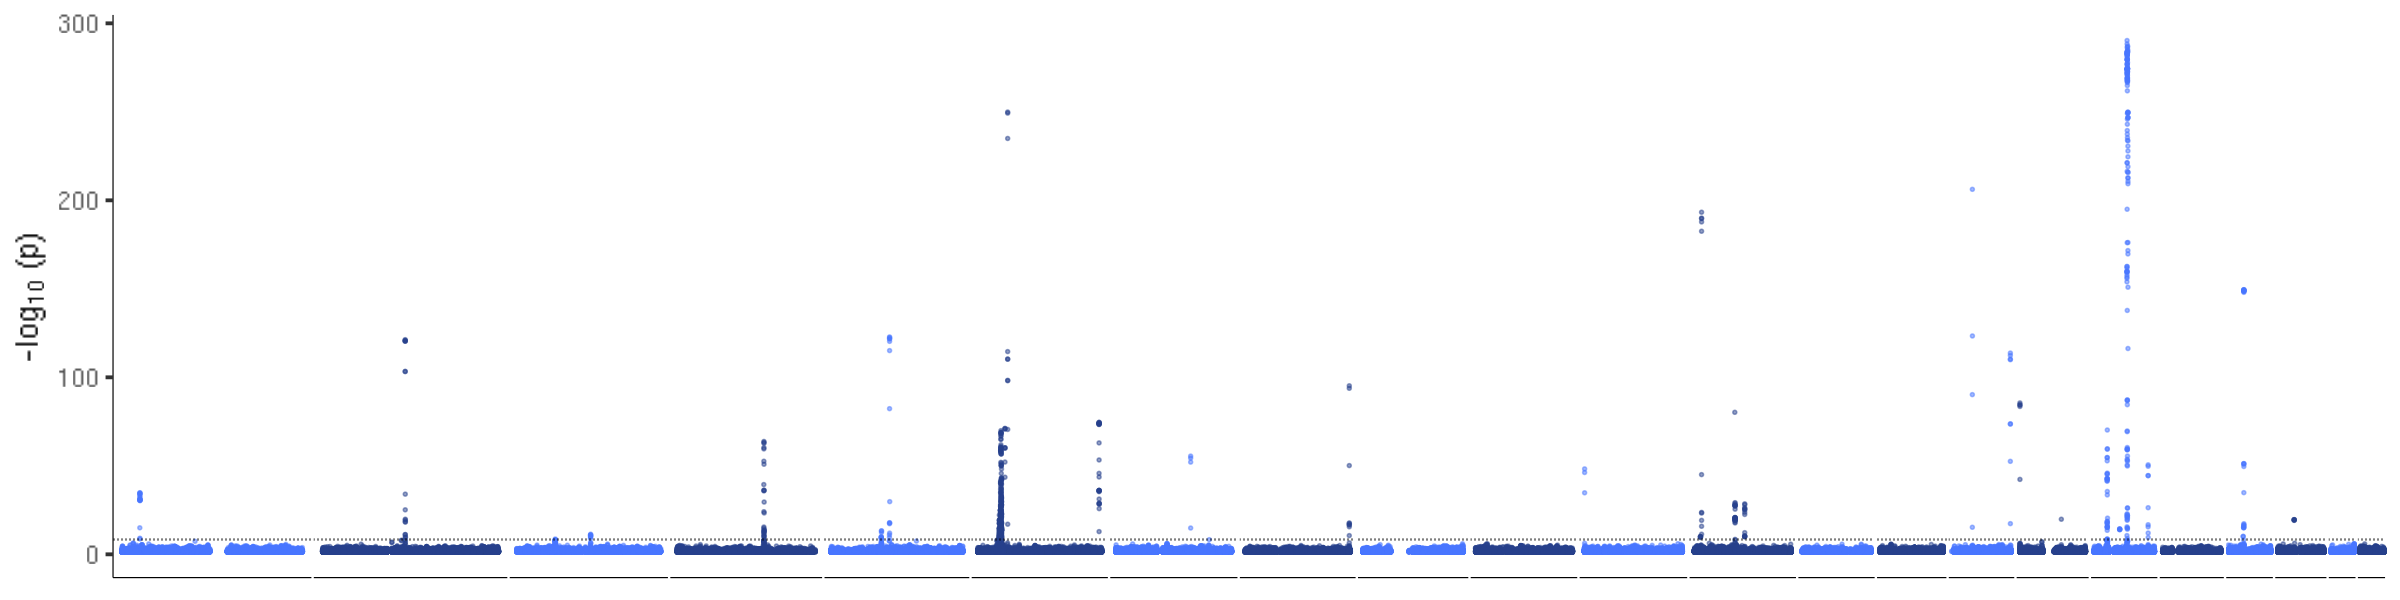

In [11]:
options(repr.plot.width=20, repr.plot.height=5)

plot.data <- me.assocs %>%
    dplyr::filter(p < 0.05) %>%
    merge(., geno, by="snp") %>%
    dplyr::filter(chr %in% 1:22) %>%
    dplyr::mutate(chr=factor(chr, levels=1:22)) %>%
    dplyr::mutate(chr.type=ifelse(as.numeric(chr) %% 2 == 0, "Even", "Odd")) %>%
    dplyr::mutate(Log.10.p = -log10(p))

plot.data %>%
    ggplot() +
    geom_point(aes(x=pos, y=Log.10.p, color=chr.type), size=I(0.5), alpha=0.5) +
    geom_hline(yintercept=-log10(0.05 / (num.modules * num.snps)), lty=3, size=0.5) +
    scale_color_manual(values=c("Even" = "royalblue4", "Odd" = "royalblue1")) +
    facet_grid(~chr, scale="free_x", space="free_x") +
    guides(color="none") +
    xlab("Position") + ylab(expression('-log'[10]~'(p)')) +
    ggplot_theme +
    theme(
        strip.background=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.spacing=unit(0.1, "lines"),
        strip.text=element_blank(),
        axis.title.x=element_blank()
    )

ggsave("04_Expression/results/manhattan_initial_pass.png", width=20, height=5, dpi=1200)

### Call Module QTL

For each module, I will create 1 Mb windows around each significant SNP. Then, I will merge these windows to create the full window for the module QTL. These will be used to calculate summary statistics for downstream colocalization analysis.

In [12]:
windows <- me.assocs %>%
    dplyr::filter(p < 0.05 / (num.modules * num.snps)) %>%
    merge(., geno, by="snp") %>%
    dplyr::mutate(start = sapply(pos, function(x) { max(1, x - 10^6) }), end = pos + 10^6 - 1)

windows.merged <- lapply(split(windows, windows$me), function(x) {
    ranges <- makeGRangesFromDataFrame(x, seqnames.field="chr", start.field="start", end.field="end") %>%
    reduce() %>%
    as.data.frame()
    ranges$me <- x$me[1]
    return(ranges)
}) %>%
    do.call(rbind, .) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

In [13]:
snp.ranges <- makeGRangesFromDataFrame(
    as.data.frame(geno.bim), 
    seqnames.field="chr", start.field="Position", end.field="Position", 
    keep.extra.columns=TRUE
)

In [14]:
overlaps <- findOverlaps(windows.merged, snp.ranges)

In [15]:
module.qtl.snps <- cbind(
    as.data.frame(windows.merged)[overlaps@from,],
    as.data.frame(snp.ranges)[overlaps@to,]
) %>%
    as.data.frame() %>%
    dplyr::select(me, snp, chr=1, start=2, end=3) %>%
    dplyr::mutate(QTL.ID=paste0(chr, ":", start, "-", end)) %>%
    dplyr::select(ME=me, SNP=snp, QTL.ID)

In [16]:
head(module.qtl.snps)

,ME,SNP,QTL.ID
,<chr>,<chr>,<chr>
ME_101.1,ME_101,rs570214486,1:24243590-26454176
ME_101.1.1,ME_101,1:24244103_0_G,1:24243590-26454176
ME_101.1.2,ME_101,rs118121369,1:24243590-26454176
ME_101.1.3,ME_101,rs141756820,1:24243590-26454176
ME_101.1.4,ME_101,rs7516592,1:24243590-26454176
ME_101.1.5,ME_101,rs12081557,1:24243590-26454176


In [17]:
write.table(
    module.qtl.snps, "~/gains_team282/nikhil/expression/eigengene_sva/mqtl_full_summary_statistics_snps.txt", 
    sep="\t", row.names=F, quote=F
)

## Circos Plot Visualization

In [18]:
chr.lengths <- read.table("~/gains_team282/epigenetics/star_genome_index/chrNameLength.txt") %>%
    dplyr::mutate(Start=1) %>%
    dplyr::select(Chr=1, Start, End=2) %>%
    dplyr::filter(Chr %in% as.character(1:22)) %>%
    dplyr::mutate(Chr = factor(Chr, levels=as.character(1:22))) %>%
    dplyr::arrange(Chr)

In [19]:
qtl.df <- module.qtl.snps %>%
    dplyr::select(ME, QTL.ID) %>%
    unique() %>%
    dplyr::mutate(Chr=factor(gsub(":.*", "", QTL.ID), levels=as.character(1:22))) %>%
    dplyr::mutate(Range=gsub(".*:", "", QTL.ID)) %>%
    dplyr::mutate(Start=as.numeric(gsub("-.*", "", Range))) %>%
    dplyr::mutate(End=as.numeric(gsub(".*-", "", Range))) %>%
    dplyr::mutate(Midpoint=(Start + End) / 2) %>%
    dplyr::mutate(Chr.Type=ifelse(as.numeric(Chr) %% 2 == 0, "royalblue4", "royalblue1"))

In [20]:
head(qtl.df)

,ME,QTL.ID,Chr,Range,Start,End,Midpoint,Chr.Type
,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
ME_101.1,ME_101,1:24243590-26454176,1,24243590-26454176,24243590,26454176,25348883,royalblue1
ME_101.2,ME_101,12:54985643-57091484,12,54985643-57091484,54985643,57091484,56038564,royalblue4
ME_102,ME_102,17:17145294-19676395,17,17145294-19676395,17145294,19676395,18410844,royalblue1
ME_103,ME_103,12:68275923-70364150,12,68275923-70364150,68275923,70364150,69320036,royalblue4
ME_104,ME_104,15:99550866-101595853,15,99550866-101595853,99550866,101595853,100573360,royalblue1
ME_105,ME_105,6:36483138-38519496,6,36483138-38519496,36483138,38519496,37501317,royalblue4


In [21]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv") %>%
    dplyr::mutate(Eigengene=paste0("ME_", gsub(".*_", "", Module)))

In [22]:
gene.info <- read.table("/nfs/team282/data/gains_team282/gene_info_864_20412_hla.txt") %>%
    dplyr::select(gene_id, seqnames, start, end) %>%
    dplyr::filter(seqnames %in% as.character(1:22)) %>%
    dplyr::mutate(seqnames=factor(seqnames, levels=as.character(1:22)))

In [23]:
mod.genes <- merge(modules, gene.info, by.x="Gene", by.y="gene_id") %>%
    merge(., qtl.df, by.x="Eigengene", by.y="ME")

In [24]:
head(mod.genes)

,Eigengene,Gene,Module,seqnames,start,end,QTL.ID,Chr,Range,Start,End,Midpoint,Chr.Type
,<chr>,<chr>,<chr>,<fct>,<int>,<int>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,ME_101,ENSG00000139531,Module_101,12,55997180,56006641,1:24243590-26454176,1,24243590-26454176,24243590,26454176,25348883,royalblue1
2,ME_101,ENSG00000139531,Module_101,12,55997180,56006641,12:54985643-57091484,12,54985643-57091484,54985643,57091484,56038564,royalblue4
3,ME_101,ENSG00000261349,Module_101,1,25266102,25267136,1:24243590-26454176,1,24243590-26454176,24243590,26454176,25348883,royalblue1
4,ME_101,ENSG00000261349,Module_101,1,25266102,25267136,12:54985643-57091484,12,54985643-57091484,54985643,57091484,56038564,royalblue4
5,ME_101,ENSG00000183726,Module_101,1,25338317,25362361,1:24243590-26454176,1,24243590-26454176,24243590,26454176,25348883,royalblue1
6,ME_101,ENSG00000183726,Module_101,1,25338317,25362361,12:54985643-57091484,12,54985643-57091484,54985643,57091484,56038564,royalblue4


In [25]:
snp.df <- me.assocs %>%
    dplyr::filter(p < 0.05) %>%
    merge(., geno, by="snp") %>%
    dplyr::filter(chr %in% 1:22) %>%
    dplyr::mutate(chr=factor(chr, levels=1:22)) %>%
    dplyr::mutate(chr.type=ifelse(as.numeric(chr) %% 2 == 0, "royalblue4", "royalblue1")) %>%
    dplyr::mutate(Log.10.p = -log10(p))

In [26]:
head(snp.df)

,snp,beta,se,t,p,me,chr,cM,pos,minor,major,chr.type,Log.10.p
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>
1,rs10000284,0.0012295213,0.0005861575,2.097595,0.036884695,ME_32,4,0,68803465,C,T,royalblue4,1.433154
2,rs10000284,-0.0006032907,0.0002283536,-2.641915,0.008495807,ME_7,4,0,68803465,C,T,royalblue4,2.070795
3,rs10000284,-0.0010884190,0.0003973057,-2.739500,0.006364121,ME_26,4,0,68803465,C,T,royalblue4,2.196262
4,rs10000284,-0.0023988480,0.0009672822,-2.479988,0.013496674,ME_73,4,0,68803465,C,T,royalblue4,1.869773
5,rs10000284,-0.0007444514,0.0003442279,-2.162670,0.030806323,ME_24,4,0,68803465,C,T,royalblue4,1.511360
6,rs10000284,-0.0015141978,0.0004654684,-3.253062,0.001223449,ME_22,4,0,68803465,C,T,royalblue4,2.912414


In [30]:
options(repr.plot.width=20, repr.plot.height=20)

png("04_Expression/results/module_qtl_circos.png", width=20, height=20, units="in", res=150)
circos.initialize(chr.lengths$Chr, xlim=chr.lengths[, c("Start", "End")])
circos.par(points.overflow.warning=F)

circos.track(ylim=c(0, max(snp.df$Log.10.p)), track.height=0.2, bg.border=F, panel.fun=function(x, y) {
    
    circos.text(CELL_META$xcenter, CELL_META$cell.ylim[1] - mm_y(0.25), CELL_META$sector.index)
    
    snp.sector = snp.df %>%
        dplyr::filter(chr == CELL_META$sector.index)
    circos.points(
        snp.sector$pos, snp.sector$Log.10.p, sector.index=CELL_META$sector.index,
        col=rgb(col2rgb(snp.sector$chr.type)[1], col2rgb(snp.sector$chr.type)[2], col2rgb(snp.sector$chr.type)[3], max=255, alpha=125),
        cex=0.5, pch=20
    )
})

circos.track(ylim=c(0, 1), track.height=0.05, bg.border=F, panel.fun=function(x, y) {
    
    qtl.sector = qtl.df %>%
        dplyr::filter(Chr == CELL_META$sector.index)
    if (nrow(qtl.sector) > 0) {
        circos.segments(
            qtl.sector$Midpoint, 0, qtl.sector$Midpoint, 1, sector.index=CELL_META$sector.index,
            col=qtl.sector$Chr.Type, lwd=2
        )
    }
})

rb4 <- rgb(col2rgb("royalblue4")[1], col2rgb("royalblue4")[2], col2rgb("royalblue4")[3], max=255, alpha=125)
rb1 <- rgb(col2rgb("royalblue1")[1], col2rgb("royalblue1")[2], col2rgb("royalblue1")[3], max=255, alpha=125)
for (i in 1:nrow(mod.genes)) {
    if (mod.genes$Chr[i] != mod.genes$seqnames[i]) {
        circos.link(
            mod.genes$Chr[i], mod.genes$Midpoint[i],
            mod.genes$seqnames[i], mod.genes[i, c("start", "end")],
            col=ifelse(as.numeric(mod.genes$Chr[i]) %% 2 == 0, rb4, rb1)
        )
    }
}
dev.off()

png 
  2

### P-Value Q-Q Plots

Under the null hypothesis, we expect p-values for multiple tests to have a uniform distribution. If there is inflation in the data (that is, variants are associated with the quantitative variable due to population stratification), this p-value distribution will be skewed towards significance. This is quantified with the genomic inflation factor ($\lambda$). We can also plot the Q-Q plot for the p-values to check for deviation from the expected distribution. The p-values for true significant hits (close to 0) should deviate from the distribution, but the rest (indicating true negatives) should follow the distribution faithfully.

In [31]:
me.assocs <- lapply(c("ME_69_1.tsv", "ME_79_1.tsv"), function(file) {
    file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", file)
    me.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
        as.data.frame() %>%
        dplyr::mutate(me = gsub("\\.tsv", "", file)) %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5, me)
})

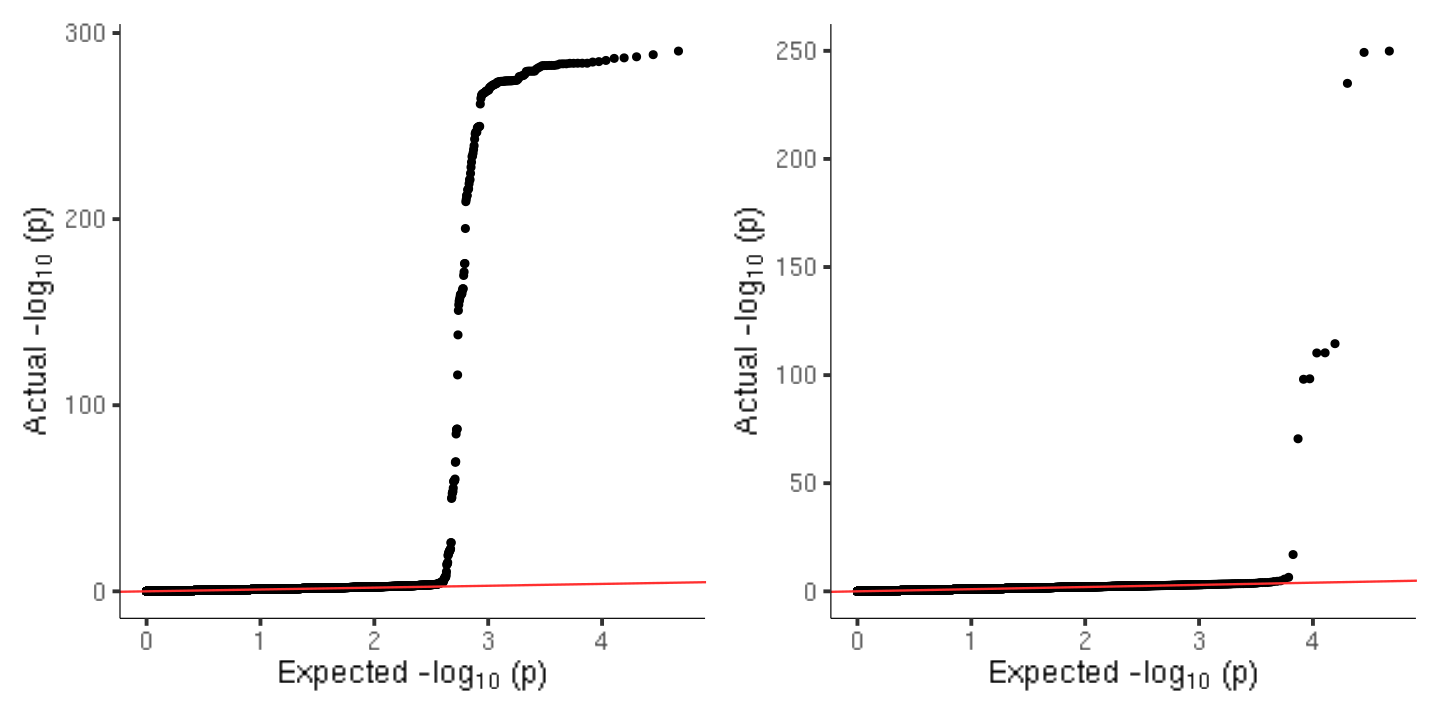

In [32]:
options(repr.plot.width=12, repr.plot.height=6)

exp.p.assocs <- lapply(me.assocs, function(me.assoc) {
    me.assoc %>%
        as.data.frame() %>%
        dplyr::mutate(expected.p=(rank(p, ties.method="first") + 0.5) / (length(p) + 1)) %>%
        dplyr::mutate(Log.10.P=-log10(p)) %>%
        dplyr::mutate(Expected.Log.10.P=-log10(expected.p))
})

plots <- lapply(exp.p.assocs, function(exp.p.assoc) {
    dplyr::bind_rows(
        exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P < 5) %>% dplyr::sample_frac(0.001),
        exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P >= 5)
    ) %>%
        ggplot() +
        geom_point(aes(x=Expected.Log.10.P, y=Log.10.P)) +
        geom_abline(slope=1, intercept=0, color="firebrick1") +
        xlab(expression("Expected -log"[10]~"(p)")) +
        ylab(expression("Actual -log"[10]~"(p)")) +
        ggplot_theme
})

plots[[1]] + plots[[2]]

## Module QTL from Multiple PCs

I have tested 5 PCs from each module for association. Here, I take the minimum p-value detected across all 5 PCs to combine evidence across the PCs.

In [33]:
files <- list.files("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", pattern="ME_.*_.*\\.tsv")
files.by.me <- lapply(split(files, gsub("_[1-5]\\.tsv", "", files)), sort)

In [34]:
me.assocs <- do.call(rbind, lapply(names(files.by.me), function(me) {
    all.pc.assoc = do.call(cbind, lapply(files.by.me[[me]], function(file) {
        file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/wgcna_initial_pass/", file)
        pc.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
            as.data.frame() %>%
            dplyr::select(snp=1, p=5)
        rownames(pc.assoc) <- pc.assoc$snp
        pc.assoc$snp <- NULL
        colnames(pc.assoc) <- gsub("\\.tsv", "", file)
        return(pc.assoc)
    }))
    me.assoc = data.frame(t(apply(all.pc.assoc, 1, function(x) {
        c(min(x), which(x == min(x))[1])
    }))) %>%
        dplyr::mutate(me = me) %>%
        dplyr::mutate(snp = rownames(.)) %>%
        dplyr::select(snp, p=1, pc=2, me)
    rownames(me.assoc) <- NULL
    return(me.assoc)
}))

In [35]:
lambdas <- me.assocs %>%
    dplyr::group_by(me) %>%
    dplyr::summarize(lambda = median(qchisq(1 - p, 1)) / qchisq(0.5, 1))

In [36]:
num.modules <- length(unique(interaction(me.assocs$me, me.assocs$pc)))
num.snps <- length(unique(me.assocs$snp))

In [37]:
mqtl.lead <- me.assocs %>%
    dplyr::filter(p < 0.05 / (num.modules * num.snps)) %>%
    merge(., geno, by="snp") %>%
    dplyr::group_by(me, chr) %>%
    dplyr::slice_min(p, n=1) %>%
    dplyr::arrange(p)

head(mqtl.lead)

snp,p,pc,me,chr,cM,pos,minor,major
<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
rs57213017,5.046513e-291,1,ME_69,17,0,45589540,C,G
rs106968,2.370055e-281,4,ME_90,1,0,7914484,G,C
rs9349181,1.318658e-250,1,ME_79,6,0,41217867,C,A
rs74011998,6.083896e-207,1,ME_97,15,0,48304516,C,T
rs9353559,1.348498e-198,3,ME_77,6,0,88449573,C,G
rs999185,5.189250e-194,1,ME_94,12,0,9960659,T,C


In [38]:
write.csv(mqtl.lead, "~/gains_team282/nikhil/expression/eigengene_sva/lead_mqtl_all_pcs.csv", row.names=F, quote=F)

In [39]:
mqtl.all <- me.assocs %>%
    dplyr::filter(p < 0.05 / (num.modules * num.snps)) %>%
    merge(., geno, by="snp") %>%
    dplyr::group_by(me, chr) %>%
    dplyr::arrange(me, chr, pos)

head(mqtl.all)

snp,p,pc,me,chr,cM,pos,minor,major
<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
rs35504893,3.582292e-10,4,ME_100,2,0,178556567,T,C
rs16866400,3.197894e-10,4,ME_100,2,0,178584184,A,G
rs1043879,1.048905e-15,1,ME_101,1,0,25243590,C,T
rs9645452,5.722824e-44,2,ME_101,1,0,25341835,T,C
rs3091242,5.166988e-42,2,ME_101,1,0,25348294,C,T
rs3093614,4.547823e-43,2,ME_101,1,0,25351353,A,T


In [40]:
write.csv(mqtl.all, "~/gains_team282/nikhil/expression/eigengene_sva/all_mqtl_all_pcs.csv", row.names=F, quote=F)

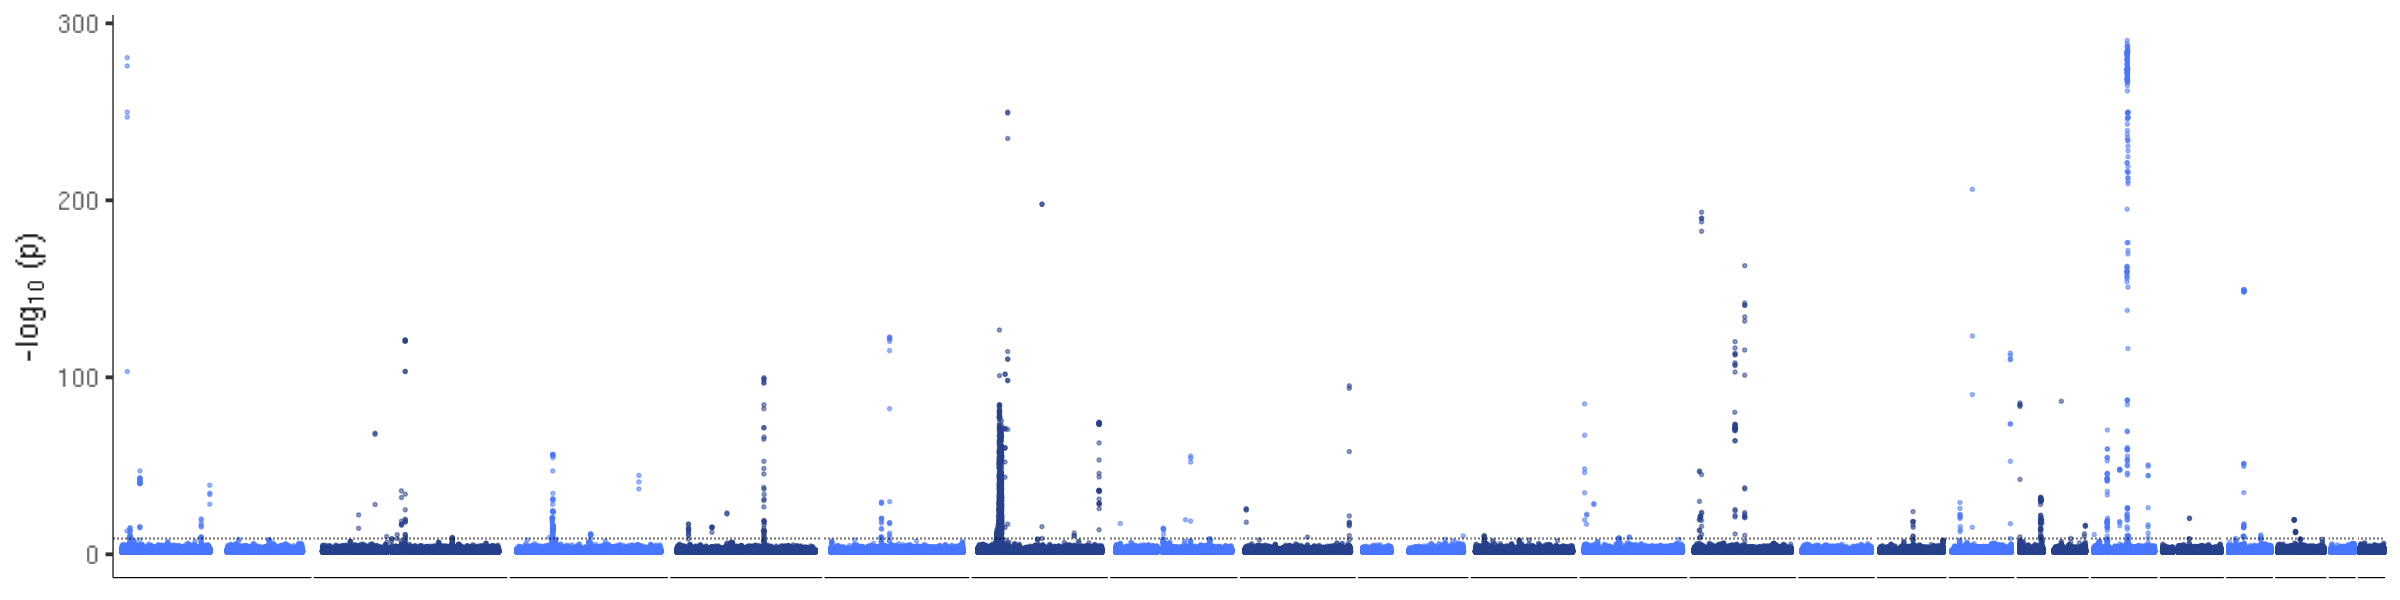

In [41]:
options(repr.plot.width=20, repr.plot.height=5)

plot.data <- me.assocs %>%
    dplyr::filter(p < 0.05) %>%
    merge(., geno, by="snp") %>%
    dplyr::filter(chr %in% 1:22) %>%
    dplyr::mutate(chr=factor(chr, levels=1:22)) %>%
    dplyr::mutate(chr.type=ifelse(as.numeric(chr) %% 2 == 0, "Even", "Odd")) %>%
    dplyr::mutate(Log.10.p = -log10(p))

plot.data %>%
    ggplot() +
    geom_point(aes(x=pos, y=Log.10.p, color=chr.type), size=I(0.5), alpha=0.5) +
    geom_hline(yintercept=-log10(0.05 / (num.modules * num.snps)), lty=3, size=0.5) +
    scale_color_manual(values=c("Even" = "royalblue4", "Odd" = "royalblue1")) +
    facet_grid(~chr, scale="free_x", space="free_x") +
    guides(color="none") +
    xlab("Position") + ylab(expression('-log'[10]~'(p)')) +
    ggplot_theme +
    theme(
        strip.background=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.spacing=unit(0.1, "lines"),
        strip.text=element_blank(),
        axis.title.x=element_blank()
    )

ggsave("04_Expression/results/manhattan_initial_pass_all_pcs.png", width=20, height=5, dpi=1200)

### Call Module QTL

For each module, I will create 1 Mb windows around each significant SNP. Then, I will merge these windows to create the full window for the module QTL. These will be used to calculate summary statistics for downstream colocalization analysis.

In [42]:
windows <- me.assocs %>%
    dplyr::filter(p < 0.05 / (num.modules * num.snps)) %>%
    merge(., geno, by="snp") %>%
    dplyr::mutate(start = sapply(pos, function(x) { max(1, x - 10^6) }), end = pos + 10^6 - 1)

windows.merged <- lapply(split(windows, windows$me), function(x) {
    ranges <- makeGRangesFromDataFrame(x, seqnames.field="chr", start.field="start", end.field="end") %>%
    reduce() %>%
    as.data.frame()
    ranges$me <- x$me[1]
    return(ranges)
}) %>%
    do.call(rbind, .) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

In [43]:
snp.ranges <- makeGRangesFromDataFrame(
    as.data.frame(geno.bim), 
    seqnames.field="chr", start.field="Position", end.field="Position", 
    keep.extra.columns=TRUE
)

In [44]:
overlaps <- findOverlaps(windows.merged, snp.ranges)

In [45]:
module.qtl.snps <- cbind(
    as.data.frame(windows.merged)[overlaps@from,],
    as.data.frame(snp.ranges)[overlaps@to,]
) %>%
    as.data.frame() %>%
    dplyr::select(me, snp, chr=1, start=2, end=3) %>%
    dplyr::mutate(QTL.ID=paste0(chr, ":", start, "-", end)) %>%
    dplyr::select(ME=me, SNP=snp, QTL.ID)

In [46]:
head(module.qtl.snps)

,ME,SNP,QTL.ID
,<chr>,<chr>,<chr>
ME_100,ME_100,rs148452704,2:177556567-179584183
ME_100.1,ME_100,rs147576295,2:177556567-179584183
ME_100.2,ME_100,2:177556998_0_G,2:177556567-179584183
ME_100.3,ME_100,rs2365616,2:177556567-179584183
ME_100.4,ME_100,rs141969740,2:177556567-179584183
ME_100.5,ME_100,rs2365617,2:177556567-179584183


In [47]:
write.table(
    module.qtl.snps, "~/gains_team282/nikhil/expression/eigengene_sva/mqtl_all_pcs_full_summary_statistics_snps.txt", 
    sep="\t", row.names=F, quote=F
)

## Circos Plot Visualization

In [48]:
chr.lengths <- read.table("~/gains_team282/epigenetics/star_genome_index/chrNameLength.txt") %>%
    dplyr::mutate(Start=1) %>%
    dplyr::select(Chr=1, Start, End=2) %>%
    dplyr::filter(Chr %in% as.character(1:22)) %>%
    dplyr::mutate(Chr = factor(Chr, levels=as.character(1:22))) %>%
    dplyr::arrange(Chr)

In [49]:
qtl.df <- module.qtl.snps %>%
    dplyr::select(ME, QTL.ID) %>%
    unique() %>%
    dplyr::mutate(Chr=factor(gsub(":.*", "", QTL.ID), levels=as.character(1:22))) %>%
    dplyr::mutate(Range=gsub(".*:", "", QTL.ID)) %>%
    dplyr::mutate(Start=as.numeric(gsub("-.*", "", Range))) %>%
    dplyr::mutate(End=as.numeric(gsub(".*-", "", Range))) %>%
    dplyr::mutate(Midpoint=(Start + End) / 2) %>%
    dplyr::mutate(Chr.Type=ifelse(as.numeric(Chr) %% 2 == 0, "royalblue4", "royalblue1"))

In [50]:
head(qtl.df)

,ME,QTL.ID,Chr,Range,Start,End,Midpoint,Chr.Type
,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
ME_100,ME_100,2:177556567-179584183,2,177556567-179584183,177556567,179584183,178570375,royalblue4
ME_101.1,ME_101,1:24243590-26454176,1,24243590-26454176,24243590,26454176,25348883,royalblue1
ME_101.2,ME_101,12:54985643-57100037,12,54985643-57100037,54985643,57100037,56042840,royalblue4
ME_101.3,ME_101,15:30215896-32681425,15,30215896-32681425,30215896,32681425,31448660,royalblue1
ME_102,ME_102,17:17145294-19676395,17,17145294-19676395,17145294,19676395,18410844,royalblue1
ME_103,ME_103,12:68275923-70376531,12,68275923-70376531,68275923,70376531,69326227,royalblue4


In [51]:
modules <- read.csv("~/gains_team282/nikhil/expression/gene_expression/modules.csv") %>%
    dplyr::mutate(Eigengene=paste0("ME_", gsub(".*_", "", Module)))

In [52]:
gene.info <- read.table("/nfs/team282/data/gains_team282/gene_info_864_20412_hla.txt") %>%
    dplyr::select(gene_id, seqnames, start, end) %>%
    dplyr::filter(seqnames %in% as.character(1:22)) %>%
    dplyr::mutate(seqnames=factor(seqnames, levels=as.character(1:22)))

In [53]:
mod.genes <- merge(modules, gene.info, by.x="Gene", by.y="gene_id") %>%
    merge(., qtl.df, by.x="Eigengene", by.y="ME")

In [54]:
head(mod.genes)

,Eigengene,Gene,Module,seqnames,start,end,QTL.ID,Chr,Range,Start,End,Midpoint,Chr.Type
,<chr>,<chr>,<chr>,<fct>,<int>,<int>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,ME_100,ENSG00000271011,Module_100,2,178577103,178577622,2:177556567-179584183,2,177556567-179584183,177556567,179584183,178570375,royalblue4
2,ME_100,ENSG00000270277,Module_100,2,178548884,178550681,2:177556567-179584183,2,177556567-179584183,177556567,179584183,178570375,royalblue4
3,ME_100,ENSG00000283709,Module_100,10,26931206,26944418,2:177556567-179584183,2,177556567-179584183,177556567,179584183,178570375,royalblue4
4,ME_100,ENSG00000279598,Module_100,2,178554561,178558966,2:177556567-179584183,2,177556567-179584183,177556567,179584183,178570375,royalblue4
5,ME_100,ENSG00000270574,Module_100,2,178578790,178580906,2:177556567-179584183,2,177556567-179584183,177556567,179584183,178570375,royalblue4
6,ME_100,ENSG00000270956,Module_100,2,178541125,178541799,2:177556567-179584183,2,177556567-179584183,177556567,179584183,178570375,royalblue4


In [55]:
snp.df <- me.assocs %>%
    dplyr::filter(p < 0.05) %>%
    merge(., geno, by="snp") %>%
    dplyr::filter(chr %in% 1:22) %>%
    dplyr::mutate(chr=factor(chr, levels=1:22)) %>%
    dplyr::mutate(chr.type=ifelse(as.numeric(chr) %% 2 == 0, "royalblue4", "royalblue1")) %>%
    dplyr::mutate(Log.10.p = -log10(p))

In [56]:
head(snp.df)

,snp,p,pc,me,chr,cM,pos,minor,major,chr.type,Log.10.p
,<chr>,<dbl>,<dbl>,<chr>,<fct>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>
1,rs10000284,0.043434279,2,ME_62,4,0,68803465,C,T,royalblue4,1.362167
2,rs10000284,0.036505994,2,ME_85,4,0,68803465,C,T,royalblue4,1.437636
3,rs10000284,0.013806445,3,ME_49,4,0,68803465,C,T,royalblue4,1.859918
4,rs10000284,0.026380808,3,ME_43,4,0,68803465,C,T,royalblue4,1.578712
5,rs10000284,0.044016026,2,ME_60,4,0,68803465,C,T,royalblue4,1.356389
6,rs10000284,0.008932153,2,ME_59,4,0,68803465,C,T,royalblue4,2.049044


In [57]:
options(repr.plot.width=20, repr.plot.height=20)

png("04_Expression/results/module_qtl_all_pcs_circos.png", width=20, height=20, units="in", res=150)
circos.initialize(chr.lengths$Chr, xlim=chr.lengths[, c("Start", "End")])
circos.par(points.overflow.warning=F)

circos.track(ylim=c(0, max(snp.df$Log.10.p)), track.height=0.2, bg.border=F, panel.fun=function(x, y) {
    
    circos.text(CELL_META$xcenter, CELL_META$cell.ylim[1] - mm_y(0.25), CELL_META$sector.index)
    
    snp.sector = snp.df %>%
        dplyr::filter(chr == CELL_META$sector.index)
    circos.points(
        snp.sector$pos, snp.sector$Log.10.p, sector.index=CELL_META$sector.index,
        col=rgb(col2rgb(snp.sector$chr.type)[1], col2rgb(snp.sector$chr.type)[2], col2rgb(snp.sector$chr.type)[3], max=255, alpha=125),
        cex=0.5, pch=20
    )
})

circos.track(ylim=c(0, 1), track.height=0.05, bg.border=F, panel.fun=function(x, y) {
    
    qtl.sector = qtl.df %>%
        dplyr::filter(Chr == CELL_META$sector.index)
    if (nrow(qtl.sector) > 0) {
        circos.segments(
            qtl.sector$Midpoint, 0, qtl.sector$Midpoint, 1, sector.index=CELL_META$sector.index,
            col=qtl.sector$Chr.Type, lwd=2
        )
    }
})

rb4 <- rgb(col2rgb("royalblue4")[1], col2rgb("royalblue4")[2], col2rgb("royalblue4")[3], max=255, alpha=125)
rb1 <- rgb(col2rgb("royalblue1")[1], col2rgb("royalblue1")[2], col2rgb("royalblue1")[3], max=255, alpha=125)
for (i in 1:nrow(mod.genes)) {
    if (mod.genes$Chr[i] != mod.genes$seqnames[i]) {
        circos.link(
            mod.genes$Chr[i], mod.genes$Midpoint[i],
            mod.genes$seqnames[i], mod.genes[i, c("start", "end")],
            col=ifelse(as.numeric(mod.genes$Chr[i]) %% 2 == 0, rb4, rb1)
        )
    }
}
dev.off()

png 
  2

## Save Convenient RDS Object

In [3]:
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.multiple.csv", row.names=1)

In [4]:
n.modules <- ncol(eigengenes)

In [5]:
n.snps = system("head -n 1 /nfs/users/nfs_n/nm18/gains_team282/nikhil/data/genotypes/eigengene_sva_genotypes.raw | sed 's/ /\\n/g' | wc -l", intern=TRUE)
n.snps = as.numeric(n.snps) - 6

In [6]:
module.ss.dir = "/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/eigengene_sva/wgcna_summary_statistics/"
module.qtl <- do.call(rbind, lapply(list.files(module.ss.dir, pattern="ME_[0-9]+_[0-9]+-.*\\.tsv"), function(file.name) {

    fread(paste0(module.ss.dir, file.name)) %>%
    as.data.frame() %>%
    dplyr::select(snp=1, beta=2, se=3, t=4, p=5) %>%
    dplyr::mutate(module.qtl=gsub("\\.tsv", "", file.name)) %>%
    dplyr::mutate(module=gsub("_[0-9]+-.*$", "", module.qtl)) %>%
    dplyr::mutate(pc=gsub("-.*$", "", gsub("ME_[0-9]+_", "", module.qtl))) %>%
    dplyr::mutate(qtl.locus=gsub("ME_[0-9]+_[0-9]+-", "", module.qtl)) %>%
    dplyr::mutate(qtl.locus.chr=gsub("\\:.*", "", qtl.locus)) %>%
    dplyr::mutate(qtl.locus.start=as.numeric(gsub(".*\\:", "", gsub("-.*$", "", qtl.locus)))) %>%
    dplyr::mutate(qtl.locus.end=as.numeric(gsub(".*-", "", qtl.locus)))
})) %>%
    dplyr::filter(p < 0.05 / (n.modules * n.snps))

In [7]:
head(module.qtl)

,snp,beta,se,t,p,module.qtl,module,pc,qtl.locus,qtl.locus.chr,qtl.locus.start,qtl.locus.end
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,rs6723399,-0.01131175,0.001791386,-6.314525,4.583147e-10,ME_100_4-2:177556567-179584183,ME_100,4,2:177556567-179584183,2,177556567,179584183
2,rs35504893,-0.01109997,0.001745267,-6.360043,3.582292e-10,ME_100_4-2:177556567-179584183,ME_100,4,2:177556567-179584183,2,177556567,179584183
3,rs16866400,-0.01081391,0.001694884,-6.380325,3.197894e-10,ME_100_4-2:177556567-179584183,ME_100,4,2:177556567-179584183,2,177556567,179584183
4,rs2255167,-0.01062098,0.001719157,-6.178015,1.083735e-09,ME_100_4-2:177556567-179584183,ME_100,4,2:177556567-179584183,2,177556567,179584183
5,rs17076,-0.01066857,0.001732812,-6.156797,1.236324e-09,ME_100_4-2:177556567-179584183,ME_100,4,2:177556567-179584183,2,177556567,179584183
6,rs1043879,0.01012981,0.001232190,8.220983,1.048905e-15,ME_101_1-1:24243590-26454176,ME_101,1,1:24243590-26454176,1,24243590,26454176


In [8]:
dim(module.qtl)

[1] 40074    12

In [ ]:
saveRDS(module.qtl, "~/gains_team282/nikhil/expression/eigengene_sva/mqtl.RDS")